In [1]:
import serial
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.spatial.transform import Rotation as R

import math

def haversine(lat1, lon1, lat2, lon2):
      R = 6372.8 #km
      dLat = math.radians(lat2 - lat1)
      dLon = math.radians(lon2 - lon1)
      lat1 = math.radians(lat1)
      lat2 = math.radians(lat2)
      a = math.sin(dLat/2)**2 + math.cos(lat1)*math.cos(lat2)*math.sin(dLon/2)**2
      c = 2*math.asin(math.sqrt(a))
      return R * c

def bearing(lat1, lon1, lat2, lon2):
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    Bearing = math.atan2(math.sin(dlon)*math.cos(lat2), 
                         math.cos(lat1)*math.sin(lat2)-math.sin(lat1)*math.cos(lat2)*math.cos(dlon))

    return Bearing

cols = ['rtcDate',
        'rtcTime',
        'Q9_1',
        'Q9_2',
        'Q9_3',
        'HeadAcc',
        'RawAX',
        'RawAY',
        'RawAZ',
        'RawGX',
        'RawGY',
        'RawGZ',
        'RawMX',
        'RawMY',
        'RawMZ',
        'output_Hz']

types = [str, # rtcDate - 01/01/2000
         str, # rtcTime - 07:24:04.91
         float, # q1
         float, # q2
         float, # q3
         float, # head acc
         float, # raw ax 
         float, # raw ay
         float, # raw az
         float, # raw gx
         float, # raw gy
         float, # raw gz
         float, # raw mx  
         float, # raw my
         float, # raw mz 
         float] # output_Hz

In [2]:
ola_ser = serial.Serial()
ola_ser_open = False
attempts = 0

#attempt to connect
while not ola_ser_open and attempts < 5:
    try:
        ola_ser = serial.Serial('com8', 115200, timeout=None)
        ola_ser_open = True
    except:
        print("Failed to open pwm serial port: ", attempts)
        
    if not ola_ser_open:
        time.sleep(0.5)
        attempts += 1

ola_ser.flushInput()

start = time.time()
log_df = pd.DataFrame(columns=cols)

while time.time() - start < 10.0:
    if ola_ser.in_waiting:
        ola_bytes = ola_ser.readline()
        # print("ola: ", ola_bytes)
        try:
            decoded_ola_strings = str(ola_bytes[0:len(ola_bytes)-2].decode("utf-8")).split(',')
            # print(decoded_ola_strings)
            if decoded_ola_strings[0] == '01/01/2000':
                out = [ty(st) for st, ty in zip(decoded_ola_strings, types)]
                log_df.loc[len(log_df)] = out
                
        except:
            print("didn't work")
            continue

ola_ser.close()
print("Complete")

Complete


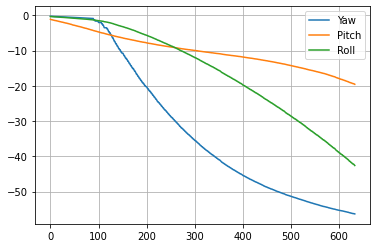

In [3]:
yaws = []
pitches = []
rolls = []
for row in log_df.itertuples():
    qx = row.Q9_1
    qy = row.Q9_2
    qz = row.Q9_3
    qw = math.sqrt( 1.0 - (qx**2 + qy**2 + qz**2))
    
    r = R.from_quat([qx, qy, qz, qw])
    ypr = r.as_euler('zyx', degrees=True)
    
    yaws.append(ypr[0])
    pitches.append(ypr[1])
    rolls.append(ypr[2])
    
log_df['Yaw'] = yaws
log_df['Pitch'] = pitches
log_df['Roll'] = rolls

# display(log_df)

plt.plot(log_df.Yaw, label='Yaw')
plt.plot(log_df.Pitch, label='Pitch')
plt.plot(log_df.Roll, label='Roll')
plt.grid()
plt.legend()
plt.show()